# Movie Recommendations
---

### Problem Statement
Build a movie recommendation system that recommends relevant movies to users based on their historical interactions and other user's preferences.

### 1. Import Python libraries

In [2]:
# import libraries for data manipulation and math calculations
import pandas as pd
import numpy as np

# import libraries for data visualization
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

# import surprise libraries for recommender systems.
from surprise import accuracy
# class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader
# class for loading datasets
from surprise.dataset import Dataset
# for model tuning model hyper-parameters
from surprise.model_selection import GridSearchCV
# for splitting the rating data in train and test dataset
from surprise.model_selection import train_test_split
# for implementing similarity based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic
# for implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD
# for implementing cross validation
from surprise.model_selection import KFold

from collections import defaultdict, OrderedDict

# import warnings library to silence some obsolete elements, such as keyword, function or class, etc.
import warnings
warnings.filterwarnings("ignore")

### 2. Import Dataset

In [3]:
df = pd.read_csv("dataset/ratings.csv")
df.head()

# The ratings dataset contains the following attributes:
#   1. userId
#   2. movieId
#   3. rating
#   4. timestamp

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


### 3. Exploratory Data Analysis

#### *a. Dataset description*

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


**Obsevation:**

- 1. There are 100,004 observations and 4 columns in the data
- 2. All the columns are of numeric data type
- 3. The data type of the timestamp column is int64 which is not correct. We can convert this to DateTime format but we don't need timestamp for our analysis. Hence, we can drop this column

In [5]:
# Dropping timestamp variable
# --------------------------------------

df.drop('timestamp', axis = 1, inplace = True)

#### *b. Univariate Analysis*

Variable: userId
--------------------------------------
Variable name: userId - User Identification Number
Variable type: int64
Variable range: 670
Total number of users: 671
Top 10 users with most interactions: [547, 564, 624, 15, 73, 452, 468, 380, 311, 30]

plot - Top 10 users with most interactions
--------------------------------------


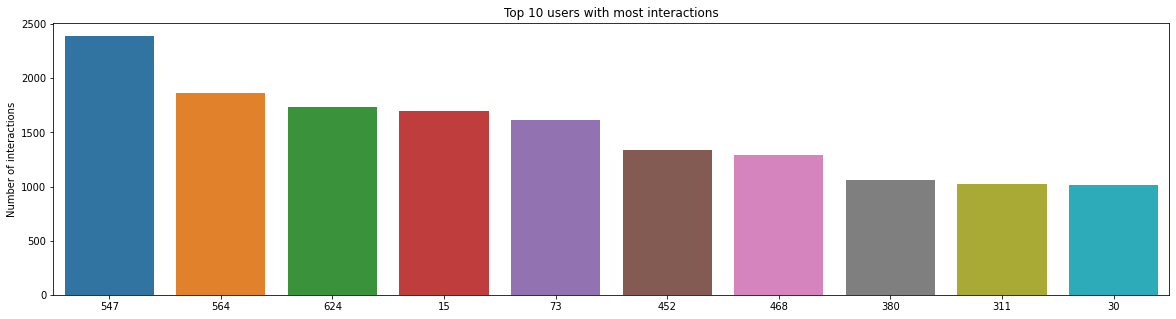

In [6]:
# userId 
# --------------------------------------
print('Variable: userId')
print('--------------------------------------')
print('Variable name: userId - User Identification Number')
print('Variable type: ' + str(df.userId.dtype))
print('Variable range: ' + str(np.ptp(df.userId)))
print('Total number of users: ' + str(df.userId.nunique()))
print('Top 10 users with most interactions: ' + str(list(df.userId.value_counts().sort_values(ascending = False).head(10).index)))

# plot
# --------------------------------------

print('')
print('plot - Top 10 users with most interactions')
print('--------------------------------------')

# creating x and y axis values
xpos = list(df.userId.value_counts().sort_values(ascending = False).head(10).index)
userInteractonsCount = list(df.userId.value_counts().sort_values(ascending = False).head(10))

plt.figure(figsize=(20,5))
plt.title('Top 10 users with most interactions')
plt.ylabel('Number of interactions')
sns.barplot(x = xpos, y = userInteractonsCount, order = xpos);
plt.show()

Variable: movieId
--------------------------------------
Variable name: movieId - Movie Identification Number
Variable type: int64
Variable range: 163948
Total number of movies: 9066
Top 10 most interacted movies [356, 296, 318, 593, 260, 480, 2571, 1, 527, 589]

plot - Top 10 movies with most interactions
--------------------------------------


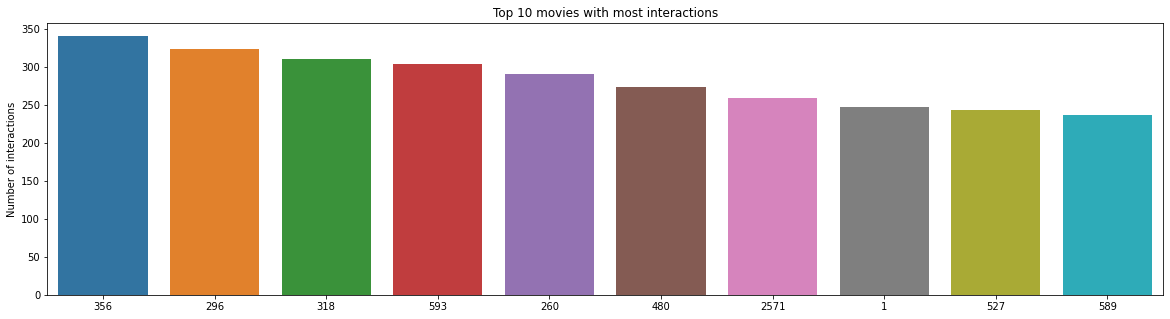

In [7]:
# movieId 
# --------------------------------------

print('Variable: movieId')
print('--------------------------------------')
print('Variable name: movieId - Movie Identification Number')
print('Variable type: ' + str(df.movieId.dtype))
print('Variable range: ' + str(np.ptp(df.movieId)))
print('Total number of movies: ' + str(df.movieId.nunique()))
print('Top 10 most interacted movies ' + str(list(df.movieId.value_counts().sort_values(ascending=False).head(10).index)))

# plot
# --------------------------------------

print('')
print('plot - Top 10 movies with most interactions')
print('--------------------------------------')

# creating x and y axis values
xpos = list(df.movieId.value_counts().sort_values(ascending=False).head(10).index)
movieInteractonsCount = list(df.movieId.value_counts().sort_values(ascending=False).head(10))

plt.figure(figsize=(20,5))
plt.title('Top 10 movies with most interactions')
plt.ylabel('Number of interactions')
sns.barplot(x = xpos, y = movieInteractonsCount, order = xpos);
plt.show()

Variable: rating
--------------------------------------
Variable name: rating - Movie rating
Variable type: float64
Total number of rating options: 10
Skew : -0.67

plot - Rating Distribution
--------------------------------------


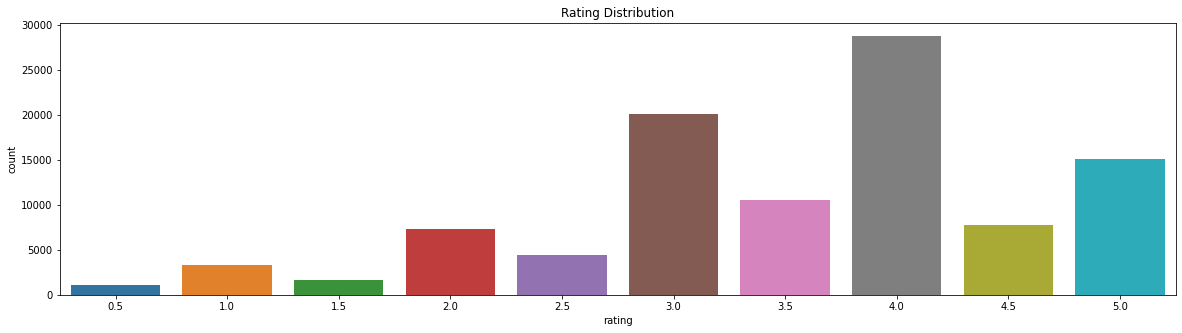

In [8]:
# rating 
# --------------------------------------
print('Variable: rating')
print('--------------------------------------')
print('Variable name: rating - Movie rating')
print('Variable type: ' + str(df.rating.dtype))
print('Total number of rating options: ' + str(df.rating.nunique()))
print('Skew :',round(df['rating'].skew(),2))

# plot
# --------------------------------------

print('')
print('plot - Rating Distribution')
print('--------------------------------------')

plt.figure(figsize=(20,5))
plt.title('Rating Distribution')
sns.countplot(x = 'rating', data = df);

**Observation**

1. Distribution of ratings is left skewed. Most ratings are in the upper side of the rating scale. 3.0 and above
2. Options 3.0, 4.0, and 5.0 are the most frequent rating options. 
3. Rating 4 is the dominant option with 1/3 (28750/100004) of the total number of observations

### 4. Data Preprocessing

#### *a. Making the dataset into surprise dataset*

In [9]:
# Making the dataset into surprise dataset and splitting it into train and test set
# --------------------------------------
# Below we are loading the rating dataset, which is a pandas dataframe, into a different format called 
# surprise.dataset.DatasetAutoFolds which is required by this library. To do this we will be using the 
# classes Reader and Dataset

# instantiating Reader scale with expected rating scale
reader = Reader(rating_scale = (0, 5))
# loading the rating dataset
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
# splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size = 0.2, random_state=42)

### 5. Model Building, Training and Testing

#### *a. Rank-Based Recommendation System:*
Provide recommendations based on the most popular items. This kind of recommendation system is useful when we have cold start problems. Cold start refers to the issue when we get a new user into the system and the machine is not able to recommend movies to the new user, as the user did not have any historical interactions in the dataset. In those cases, we can use rank-based ecommendation system to recommend movies to the new user.


In [10]:
# Rank-based recommendation systems 
# --------------------------------------
# To build the rank-based recommendation system, we take the 'average' of all the ratings provided to each 
# movie and then rank them based on their average rating

# calculating average ratings
average_rating = df.groupby('movieId').mean()['rating']
# calculating the count of ratings
count_rating = df.groupby('movieId').count()['rating']
# making a dataframe with the count and average of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})
print(final_rating)

         avg_rating  rating_count
movieId                          
1          3.872470           247
2          3.401869           107
3          3.161017            59
4          2.384615            13
5          3.267857            56
...             ...           ...
161944     5.000000             1
162376     4.500000             1
162542     5.000000             1
162672     3.000000             1
163949     5.000000             1

[9066 rows x 2 columns]


In [11]:
# Find the top n movies with 'x' number of interactions for a recommendation
# --------------------------------------
# Now, let's create a function to find the top n movies for a recommendation based on the average ratings of
# movies. We can also add a threshold for a minimum number of interactions for a movie to be considered for 
# recommendation.

def top_n_movies(data, n, min_interaction = 100):
    
    # finding movies with minimum number of interactions
    recommendations = data[data['rating_count'] > min_interaction]
    # sorting values w.r.t average rating 
    recommendations = recommendations.sort_values(by = 'avg_rating', ascending = False)
    # return list of top n movies recomendations
    return recommendations.index[:n]


In [12]:
# testing - Rank-based recommendation systems 
# --------------------------------------

top_n_movies(final_rating, 10, 200).to_list()

[318, 50, 527, 608, 296, 2858, 1196, 260, 1198, 2571]

#### *b. User based Collaborative Filtering Recommendation System (User Similarity)* 

Technique used to predict the items that a user might like on the basis of ratings given to that item by the other users who have similar taste. This allows for serendipitous recommendations; that is, collaborative filtering models can recommend an item to user A based on the interests of a similar user B. 

In [13]:
# baseline - User Similarity recommendation system 
# --------------------------------------

# defining algorithm using KNN and cosine similarity
algo_knn_user = KNNBasic(sim_options = {'name': 'cosine', 'user_based':True}, verbose = False)
# train the algorithm on the trainset or fitting the model on train dataset 
algo_knn_user.fit(trainset)
# predict ratings for the testset
predictions = algo_knn_user.test(testset)
# computing RMSE
x = accuracy.rmse(predictions, verbose = False)

print('Baseline Performance')
print('# --------------------------------------')
print('Baseline RMSE : ',  round(x,4))

Baseline Performance
# --------------------------------------
Baseline RMSE :  0.9925


In [14]:
# testing baseline - User Similarity recommendation system 
# --------------------------------------

# Predicting rating for userId = 4, movieId = 10. True rating value is 4 
x =  algo_knn_user.predict(4, 10, r_ui = 4, verbose = False)

print('Baseline Results')
print('# --------------------------------------')
print('Baseline prediction : estimate =',  round(x[3],2), ' | true_rate =', x[2])

Baseline Results
# --------------------------------------
Baseline prediction : estimate = 3.62  | true_rate = 4


In [15]:
# optimizing - User Similarity recommendation system 
# --------------------------------------

# setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }

# performing 3-fold cross validation to tune the hyperparameters
grid_obj = GridSearchCV(KNNBasic, param_grid, measures = ['rmse', 'mae'], cv = 3, n_jobs = -1)
# fitting the data
grid_obj.fit(data)

print('Optimized Results')
print('# --------------------------------------')
print('Best RMSE : ', round(grid_obj.best_score['rmse'],4))
print('Best ombination of parameters : ', grid_obj.best_params['rmse'])


Optimized Results
# --------------------------------------
Best RMSE :  0.9644
Best ombination of parameters :  {'k': 20, 'min_k': 3, 'sim_options': {'name': 'msd', 'user_based': True}}


In [16]:
# optimized - User Similarity recommendation system  
# --------------------------------------

# defining algorithm using KNN and cosine similarity with optimal hyperparameter values
algo_knn_user_optimized = KNNBasic( k = 20, min_k = 3, verbose = False,
                                        sim_options = {'name': 'msd', 'user_based': True})
# training the algorithm on the trainset
algo_knn_user_optimized.fit(trainset)
# predicting ratings for the testset
predictions = algo_knn_user_optimized.test(testset)
# computing RMSE on testset
x = accuracy.rmse(predictions, verbose = False)

print('Optimized Performance')
print('# --------------------------------------')
print('Optimized RMSE : ',  round(x,4))


Optimized Performance
# --------------------------------------
Optimized RMSE :  0.9571


In [17]:
# testing optimized - User Similarity recommendation system  
# --------------------------------------
# Predicting rating for userId = 4, movieId = 10. True rating value is 4 

x =  algo_knn_user_optimized.predict(4, 10, r_ui = 4, verbose = False)

print('Optimized Results')
print('# --------------------------------------')
print('prediction : estimate_rating =',  round(x[3],2), ' | true_rating =', x[2])

Optimized Results
# --------------------------------------
prediction : estimate_rating = 3.74  | true_rating = 4


**Observation:**

* Best RMSE (after hypertuning parameters) for **User Similarity** is 0.9548.
* For tested user/movie, perdicton improved from 3.54 to 3.63 for true rate = 4) 


#### *c. Item based Collaborative Filtering Recommendation System (Item Similarity)*

Looks for similar items based on the items users have already liked or positively interacted with.

In [18]:
# baseline - Item Similarity recommendation system 
# --------------------------------------

# definfing item similarity measure
sim_options = {'name': 'cosine', 'user_based': False}
# defining Nearest neighbour algorithm
algo_knn_item = KNNBasic(sim_options = sim_options, verbose = False)
# train the algorithm on the trainset or fitting the model on train dataset 
algo_knn_item.fit(trainset)
# predict ratings for the testset
predictions = algo_knn_item.test(testset)
# computing RMSE
x = accuracy.rmse(predictions, verbose = False)

print('Baseline Performance')
print('# --------------------------------------')
print('Baseline RMSE : ',  round(x, 4))

Baseline Performance
# --------------------------------------
Baseline RMSE :  1.0032


In [19]:
# testing - Item Similarity recommendation system 
# --------------------------------------

# Predicting rating for userId = 4, movieId = 10. True rating value is 4 
x = algo_knn_item.predict(4, 10, r_ui = 4, verbose = False)

print('Baseline Results')
print('# --------------------------------------')
print('prediction : estimate_rating =',  round(x[3], 2), ' | true_rating =', x[2])

Baseline Results
# --------------------------------------
prediction : estimate_rating = 4.37  | true_rating = 4


In [20]:
# optimizing - Item Similarity recommendation system 
# --------------------------------------

# setting up parameter grid to tune the hyperparameters
param_grid = {'k':[20, 30], 'k_min':[3], 
              'sim_options':{'name':['msd','cosine'],
                             'user_based':[False]}
             }
# performing 3-fold cross validation to tune the hyperparameters
grid_obj = GridSearchCV(KNNBasic, param_grid, measures = ['rmse', 'mae'], cv = 3, n_jobs = -1)
# fitting the data
grid_obj.fit(data)
# best RMSE score

print('Optimized Results')
print('# --------------------------------------')
print('Best RMSE : ', round(grid_obj.best_score['rmse'],4))
print('Best ombination of parameters : ', grid_obj.best_params['rmse'])

Optimized Results
# --------------------------------------
Best RMSE :  0.9445
Best ombination of parameters :  {'k': 30, 'k_min': 3, 'sim_options': {'name': 'msd', 'user_based': False}}


In [21]:
# optimized - Item Similarity recommendation system  
# --------------------------------------

# creating an instance of KNNBasic with optimal hyperparameter values
algo_knn_item_optimized = KNNBasic(sim_options = {'name':'cosine','user_based': False}, k = 30, 
                                            min_k = 3, verbose = False)
# training the algorithm on the trainset
algo_knn_item_optimized.fit(trainset)
# predicting ratings for the testset
predictions = algo_knn_item_optimized.test(testset)
# computing RMSE on testset
x = accuracy.rmse(predictions, verbose = False)

print('Optimized Performance')
print('# --------------------------------------')
print('Optimized RMSE : ',  round(x,4))

Optimized Performance
# --------------------------------------
Optimized RMSE :  1.011


In [22]:
# testing - hypertuned params item similarity based recommendation system
# --------------------------------------

# rating for userId = 4 and movieId = 10 with the optimized model
x = algo_knn_item_optimized.predict(4, 10, r_ui = 4, verbose = False)

print('Optimized Results')
print('# --------------------------------------')
print('prediction : estimate_rating =',  round(x[3],2), ' | true_rating =', x[2])

Optimized Results
# --------------------------------------
prediction : estimate_rating = 4.27  | true_rating = 4


#### *d. Collaborative Filtering - Matrix Factorization using SVD*

* Model-based Collaborative Filtering is a personalized recommendation system, the recommendations are 
based on the past behavior of the user and it is not dependent on any additional information. We use 
latent features to find recommendations for each user.

* Latent Features: The features that are not present in the empirical data but can be inferred from the data

In [23]:
# baseline - matrix factorization svd
# --------------------------------------

# using SVD matrix factorization
algo_svd = SVD()
# training the algorithm on the trainset
algo_svd.fit(trainset)
# predicting ratings for the testset
predictions = algo_svd.test(testset)
# computing RMSE on the testset
x = accuracy.rmse(predictions , verbose=False)

print('Baseline Performance')
print('# --------------------------------------')
print('Baseline RMSE : ',  round(x, 4))


Baseline Performance
# --------------------------------------
Baseline RMSE :  0.9053


In [24]:
# testing - baseline matrix factorization svd
# --------------------------------------

# Predicted rating for an user with userId = 4 and for movieId = 10
x = algo_svd.predict(4, 10, r_ui = 4, verbose = False)

print('Baseline Results')
print('# --------------------------------------')
print('Baseline prediction : estimate =',  round(x[3], 2), ' | true_rate =', x[2])

Baseline Results
# --------------------------------------
Baseline prediction : estimate = 3.89  | true_rate = 4


In [25]:
# optimizing - matrix factorization svd
# --------------------------------------

# set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}
# performing 3-fold gridsearch cross validation
gs = GridSearchCV(SVD, param_grid, measures = ['rmse', 'mae'], cv = 3, n_jobs = -1)
# fitting data
gs.fit(data)

print('Optimized Results')
print('# --------------------------------------')
print('Best RMSE : ', round(grid_obj.best_score['rmse'], 4))
print('Best ombination of parameters : ', grid_obj.best_params['rmse'])

Optimized Results
# --------------------------------------
Best RMSE :  0.9445
Best ombination of parameters :  {'k': 30, 'k_min': 3, 'sim_options': {'name': 'msd', 'user_based': False}}


In [26]:
# optimized - matrix factorization svd 
# --------------------------------------

# building the optimized SVD model using optimal hyperparameter search
algo_svd_optimized = SVD(n_epochs=30, lr_all=0.01, reg_all=0.2)
# training the algorithm on the trainset
algo_svd_optimized.fit(trainset)
# predicting ratings for the testset
predictions = algo_svd_optimized.test(testset)
# computing RMSE
x = accuracy.rmse(predictions, verbose = False)

print('Optimized Performance')
print('# --------------------------------------')
print('Optimized RMSE : ',  round(x, 4))

Optimized Performance
# --------------------------------------
Optimized RMSE :  0.8952


In [27]:
# testing - optimized baseline matrix factorization svd
# --------------------------------------

# Predicted rating for an user with userId = 4 and for movieId = 10
x = algo_svd_optimized.predict(4, 10, r_ui = 4, verbose = False)

print('Optimized Results')
print('# --------------------------------------')
print('prediction : estimate_rating =',  round(x[3], 2), ' | true_rating =', x[2])

Optimized Results
# --------------------------------------
prediction : estimate_rating = 3.98  | true_rating = 4


### 6. Results

**svd_algo_optimized** may be considered as the best performing model for this dataset.	

It's performing metrics are:

1. RMSE: 0.899653
2. Precision = 0.732 & Recall = 0.526 at K = 10 (Top 10 recommendations)

**Rank-Based Recommendation System** is a good model for all new users who haven’t had interactions with the system yet. And it can coexist with the **svd_algo_optimized** in production environment

Find below all details about its performance and some more testing and evaluation

#### *a. Selecting the best performing  model base on RMSE results*

In [28]:

models = [algo_knn_user, algo_knn_user_optimized, algo_knn_item, algo_knn_item_optimized, algo_svd, 
            algo_svd_optimized]

scores = []

for model in models:
    model.fit(trainset)
    predictions = model.test(testset)
    score = accuracy.rmse(predictions , verbose = False)
    scores.append(score)


modelsNames = ['algo_knn_user', 'algo_knn_user_optimized', 'algo_knn_item', 'algo_knn_item_optimized', 
                'algo_svd', 'svd_algo_optimized']

dfScore = pd.DataFrame()
dfScore['RecomMendationSystem'] = modelsNames
dfScore['RMSE'] = scores
dfScore = dfScore.sort_values(by='RMSE', ascending=True)

dfScore

# sns.barplot(y = 'RecomendationSystem', x = 'RMSE', data = dfScore)

,RecomMendationSystem,RMSE
5,svd_algo_optimized,0.895173
4,algo_svd,0.898313
1,algo_knn_user_optimized,0.957145
0,algo_knn_user,0.992451
2,algo_knn_item,1.003221
3,algo_knn_item_optimized,1.011045


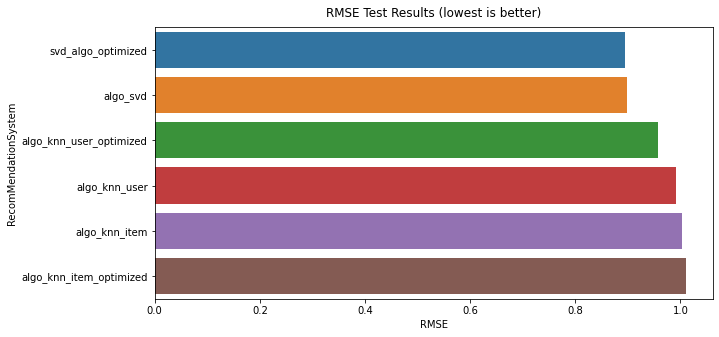

In [29]:
# RMSE Chart
# --------------------------------------

fig = plt.figure(figsize=(10,5))
sns.barplot(y = 'RecomMendationSystem', x = 'RMSE', data = dfScore)
plt.title('RMSE Test Results (lowest is better)', pad = 10)
plt.show

# --------------------------------------
fig.savefig('./imgs/rmse_plt.jpg')

**Comments:** 

svd_algo_optimized RMSE = 0.899653. This is the model with lowest error.

root mean squered error (RMSE): is a measure of  error. In other words, it tells the different from the true rate. *Lower value means best fit / Data is closer to the prediction*

#### *b. Precision & Recall at K*

In [30]:
# Precision & Recall at K (number of recomendations)
# --------------------------------------
# Args:
#   a. predictions: 
#   b. k: number of predictions to select 
#   c. threshold: minimum for ratings to be considered as relevant

def precision_recall_at_k(predictions, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()

    for uid, user_ratings in user_est_true.items():
        
        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)
        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in user_ratings[:k])
        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [31]:
# A basic cross-validation iterator.
kf = KFold(n_splits = 5)
# Make list of k values
K = [5, 10]
# Each model name str format
modelsNames = ['algo_knn_user', 'algo_knn_user_optimized', 'algo_knn_item', 'algo_knn_item_optimized', 
                'algo_svd', 'svd_algo_optimized']

# Incremental variable to loop of over modelsNames
i = 0
prec = dict()
rec = dict()
# Make list of models (objects)
models = [algo_knn_user, algo_knn_user_optimized, algo_knn_item, algo_knn_item_optimized, algo_svd, 
            algo_svd_optimized]
# Calculating average Precision and Recall for each model.
for model in models:
    print('model: ' + str(modelsNames[i]))
    print('# --------------------------------------')
    
    i = i + 1
    
    for k in K:

        p = []
        r = []

        for trainset, testset in kf.split(data):        
            model.fit(trainset)
            predictions = model.test(testset, verbose = False)
            precisions, recalls = precision_recall_at_k(predictions, k = k, threshold = 3.5)

            # Precision and recall can then be averaged over all users
            p.append(sum(prec for prec in precisions.values()) / len(precisions))
            r.append(sum(rec for rec in recalls.values()) / len(recalls))
        
        print('top: ' + str(k), ' -- Precision: ', round(sum(p) / len(p), 3), 
            '-- Recall: ', round(sum(r) / len(r), 3))

        prec[k] = round(sum(p) / len(p), 3)
    
    print('')


model: algo_knn_user
# --------------------------------------
top: 5  -- Precision:  0.773 -- Recall:  0.414
top: 10  -- Precision:  0.747 -- Recall:  0.546

model: algo_knn_user_optimized
# --------------------------------------
top: 5  -- Precision:  0.776 -- Recall:  0.424
top: 10  -- Precision:  0.753 -- Recall:  0.559

model: algo_knn_item
# --------------------------------------
top: 5  -- Precision:  0.603 -- Recall:  0.318
top: 10  -- Precision:  0.599 -- Recall:  0.477

model: algo_knn_item_optimized
# --------------------------------------
top: 5  -- Precision:  0.612 -- Recall:  0.33
top: 10  -- Precision:  0.6 -- Recall:  0.48

model: algo_svd
# --------------------------------------
top: 5  -- Precision:  0.755 -- Recall:  0.385
top: 10  -- Precision:  0.738 -- Recall:  0.52

model: svd_algo_optimized
# --------------------------------------
top: 5  -- Precision:  0.751 -- Recall:  0.387
top: 10  -- Precision:  0.734 -- Recall:  0.524



**Comments:**

model: **svd_algo_optimized** shows good values at k = 10 (top 10 recomendations)

top: 10  -- Precision:  0.732 -- Recall:  0.526

* Precision@K: Proportion of recommended items that are relevant
* Recall@K: Proportion of relevant items that are recommended

#### *C. Implementing the recommendation algorithm for non interacted movies*

In [51]:
# Implementing the recommendation algorithm
# --------------------------------------

# Below we will be implementing a function where the input parameters are:
#   data: a rating dataset
#   user_id: an user id against which we want the recommendations
#   top_n: the number of movies we want to recommend
#   algo: the algorithm we want to use to predict the ratings

def get_recommendations(data, user_id, top_n, algo):
    
    # creating an empty list to store the recommended movie ids
    recommendations = []    
    # creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index = 'userId', columns = 'movieId', values = 'rating')
    # extracting those movie ids which the user_id has not interacted yet
    non_interacted_movies = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    #interacted_movies = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].notnull()].index.tolist()

    # looping through each of the movie id which user_id has not interacted yet
    for item_id in non_interacted_movies:
        # predicting the ratings for those non interacted movie ids by this user
        est = round(algo.predict(user_id, item_id).est, 2)
        # appending the predicted ratings
        recommendations.append((item_id, est))

    # sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)
    # returing top n highest predicted rating movies for this user
    return recommendations[:top_n]

In [53]:
# Predict the top 10 movie recommendations for userId = 4
# --------------------------------------

recommendations = get_recommendations(df, 4, 10, algo_svd_optimized)
recommendations

[(1361, 5),
 (1939, 5),
 (3038, 5),
 (4903, 5),
 (73290, 5),
 (8132, 4.98),
 (3030, 4.97),
 (3181, 4.97),
 (7502, 4.97),
 (5114, 4.96)]

#### *d. Predicting ratings for already interacted movies & Precision & Recall for a single user at K*

In [34]:
# Predicting ratings for already interacted movies
# --------------------------------------
# Comparing the rating predictions of users for those movies which has been already watched by an user. This will help us to understand 
# how well are predictions compared to the actual ratings provided by users

def predict_already_interacted_ratings(data, user_id, algo):
    
    # creating an empty list to store the recommended movie ids
    recommendations = []
    # creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index='userId', columns='movieId', values='rating')
    # extracting those movie ids which the user_id has interacted already
    interacted_movies = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].notnull()].index.tolist()
    
    # looping through each of the movie id which user_id has interacted already
    for item_id in interacted_movies:
        # extracting actual ratings
        actual_rating = user_item_interactions_matrix.loc[user_id, item_id]
        # predicting the ratings for those non interacted movie ids by this user
        predicted_rating = algo.predict(user_id, item_id).est
        # appending the predicted ratings
        recommendations.append((user_id, item_id, actual_rating, predicted_rating))

    # sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse=True)
    # returning top n highest predictions
    return pd.DataFrame(recommendations, columns=['userId', 'movieId', 'true_rating', 'estimated_rating']) 

In [35]:
# Precision & Recall for a single user at K (number of recomendations)
# --------------------------------------

def user_precision_recall(predictions, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    # user_est_true = defaultdict(list)
    est_true = []

    for _, _, true_r, est in predictions:
        est_true.append((est, true_r))

    # Sort user ratings by estimated value
    est_true.sort(key = lambda x: x[0], reverse = True)
    # Number of relevant items
    n_rel = sum((true_r >= threshold) for (_, true_r) in est_true)
    # Number of recommended items in top k
    n_rec_k = sum((est >= threshold) for (est, _) in est_true[:k])
    # Number of relevant and recommended items in top k
    n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in est_true[:k])
    # Precision@K: Proportion of recommended items that are relevant
    # When n_rec_k is 0, Precision is undefined. We here set it to 0.
    precision = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
    # Recall@K: Proportion of relevant items that are recommended
    # When n_rel is 0, Recall is undefined. We here set it to 0.
    recall = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precision, recall

##### *Single user Precision and Recall for top 10 predictions of already interacted movies*

In [36]:
predicted_ratings_for_interacted_movies = predict_already_interacted_ratings(df, 4, algo_svd_optimized)
precision, recall = user_precision_recall(predicted_ratings_for_interacted_movies.to_numpy(), k = 10, threshold = 3.5)

'''
Relevant : Movies which true_ratings are equal or bigger than threshold
Precision : Proportion of recommended items that are relevant
Recall : Proportion of relevant items that are recommended
'''

print('Precision, Recall')
print('# --------------------------------------')
print('Precision: %0.2f  ' % (precision)) 
print('Recall: %0.2f  ' % (recall)) 

Precision, Recall
# --------------------------------------
Precision: 1.00  
Recall: 0.06  


**Comments:**

* Precision: 1.00 > All top K recommended movies are relevant too
* Recall: 0.06 > Out of all relevant movies only top k where commended


##### *Plot True_rating vs Estimated_rating Distribution for user already interacted movies*

<function matplotlib.pyplot.show(close=None, block=None)>

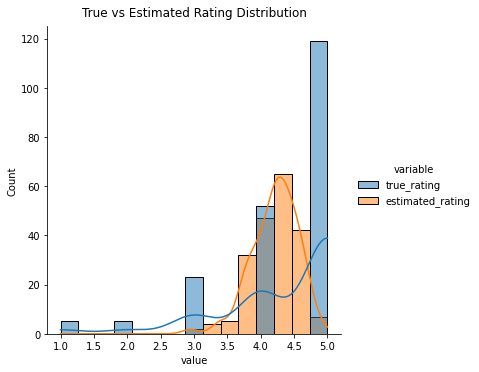

In [42]:
# Plot True_rating vs Estimated_rating Distribution
# --------------------------------------
predicted_ratings_for_interacted_movies = predict_already_interacted_ratings(df, 4, algo_svd_optimized)
dfPRIM = predicted_ratings_for_interacted_movies.melt(id_vars = 'movieId', value_vars = ['true_rating', 'estimated_rating'])

sns.displot(data = dfPRIM, x = 'value', hue = 'variable', kde = True)
plt.title('True vs Estimated Rating Distribution', pad = 10)
plt.show


#### *e. Return the top-N recommendation for each user from a set of predictions*

In [61]:
# Return the top-N recommendation for each user from a set of predictions.
# --------------------------------------
# Arguments:
#   a. predictions (list of Prediction objects): The list of predictions, as returned 
#      by the test method of an algorithm.
#   b. n(int): The number of recommendations to output for each user. Default is 10.
#
# Returns: A dictionary where keys are user (raw) ids and values are lists of tuples:
#          [(raw item id, rating estimation), ...] of size n.

def get_top_n(predictions, n = 10):
    
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key = lambda x: x[1], reverse = False)
        top_n[uid] = user_ratings[:n]

    return top_n

In [60]:
# Predicting top-N recommendations for each user
# --------------------------------------

# Using algo_svd_optimized model to make recommendations
predictions = algo_svd_optimized.test(testset, verbose = False)
# Return the top-N recommendation for each user 
top_n = get_top_n(predictions, n = 10)
# sorting user in ascending order
od = OrderedDict(sorted(top_n.items()))
# Print the recommended items for each user
for uid, user_ratings in od.items():
    print(uid, [iid for (iid, _) in user_ratings])

1 [1371, 1405, 1061]
2 [208, 585, 485, 317, 248, 185, 552, 550, 468, 500]
3 [2841, 8636, 1884, 2716, 866, 1210, 296, 593, 527]
4 [2986, 1388, 2699, 2002, 434, 1858, 367, 2034, 1030, 410]
5 [586, 788, 4018, 8376, 277, 33679, 5266, 1380, 30793, 2081]
6 [1687, 3751, 596, 1639, 3114, 2761, 2502, 1259, 2019]
7 [786, 724, 610, 31, 1125, 1302, 34, 151, 345, 595]
8 [5378, 1552, 45, 1302, 524, 2353, 2139, 8784, 6879, 4034]
9 [2140, 2302]
10 [1459, 2841, 1127, 2406, 152, 3019, 2890, 1036, 1423, 318]
11 [2042, 58295, 80906, 97938, 1201]
12 [3146, 3861, 3798, 736, 3794, 3176, 3879, 2355, 2529, 3801]
13 [2355, 914, 4321, 6377, 64614, 2761, 81834, 2762, 3147, 47]
14 [3986, 2724, 3623, 2861, 3751, 594]
15 [3113, 1831, 5504, 3286, 2568, 1862, 5313, 7173, 4654, 3316]
16 [4231, 4823, 2706, 4246, 4772, 1704]
17 [5881, 172, 34048, 185, 3863, 8865, 3994, 3262, 8783, 5015]
18 [79, 748, 14, 141, 733, 25, 36]
19 [1381, 42, 1091, 344, 208, 407, 1373, 612, 231, 122]
20 [153, 3555, 597, 1378, 2405, 31116, 2013, 